In [1]:
import numpy as np
from dolfinx.mesh import create_rectangle, CellType
from mpi4py import MPI
from pybandgap.set_structure import fine_irreducible_brillouin_zone, get_midpoint_elements, Material, Props
from pybandgap.plot_mesh import plot_IBZ, plot_structure
from pybandgap.bandgap import bandgap
from pybandgap.mass_and_stiffness_matrix import matrix_and_stiffness_matrix

a = 20e-3
nx = 20
ny = nx
msh = create_rectangle(MPI.COMM_WORLD, np.array([[-a,-a],[a,a]]), [nx, ny], CellType.quadrilateral)

In [2]:
elements, IBZ_condition = fine_irreducible_brillouin_zone(msh)

In [3]:
print(elements)

[219 238 255 256 272 273 287 288 289 302 303 304 315 316 317 318 328 329
 330 331 339 340 341 342 343 350 351 352 353 354 359 360 361 362 363 368
 369 370 371 375 376 377 378 382 383 384 387 388 389 392 393 395 396 398
 399]


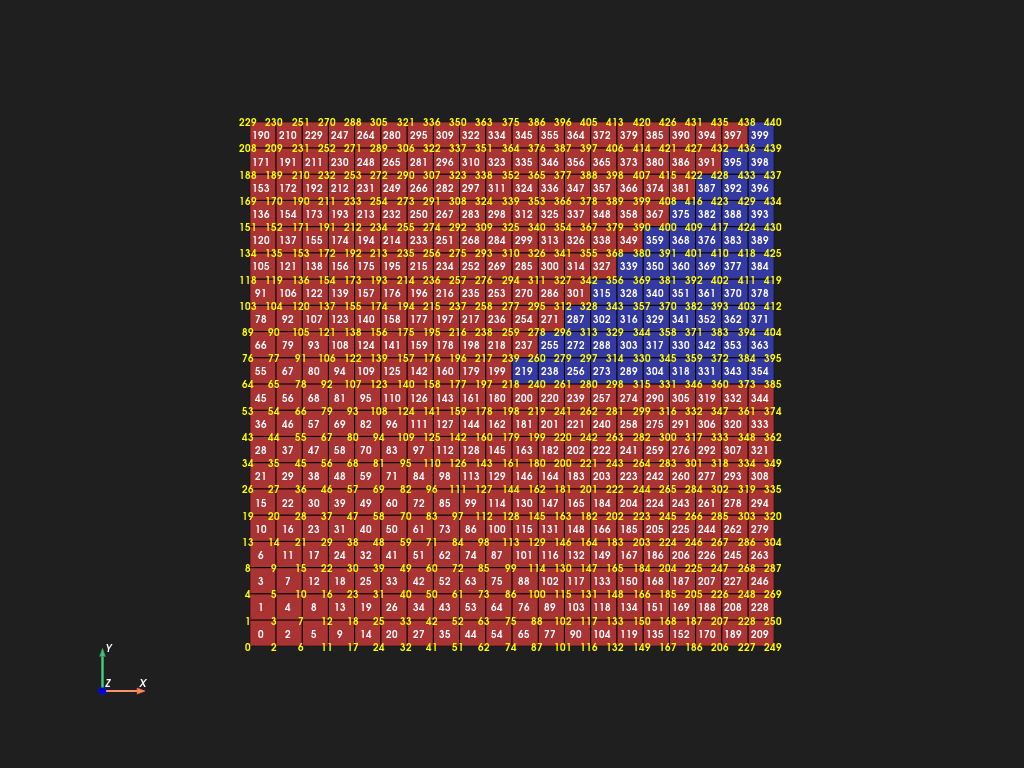

In [4]:
plot_IBZ(msh, elements)

In [5]:
centers = get_midpoint_elements(msh)

condition_1 = centers[:,0]<= 0.012
condition_2 = centers[:,1]<= 0.012

condition = np.vstack((IBZ_condition, condition_1, condition_2))

tungsten_elements = np.where(np.all(condition, axis=0))[0]

In [6]:
aluminio = Material('aluminio', young_modulus=70e9, poisson_ratio=0.33, density=2.7e3)
tungsteno = Material('tungsteno', young_modulus=411e9, poisson_ratio=0.28, density=19.3e3)

In [7]:
material_elements = np.array([
    tungsteno if i in tungsten_elements else aluminio
    for i in elements])

In [8]:
props = Props(msh)
props.set_prop('materials', material_elements)

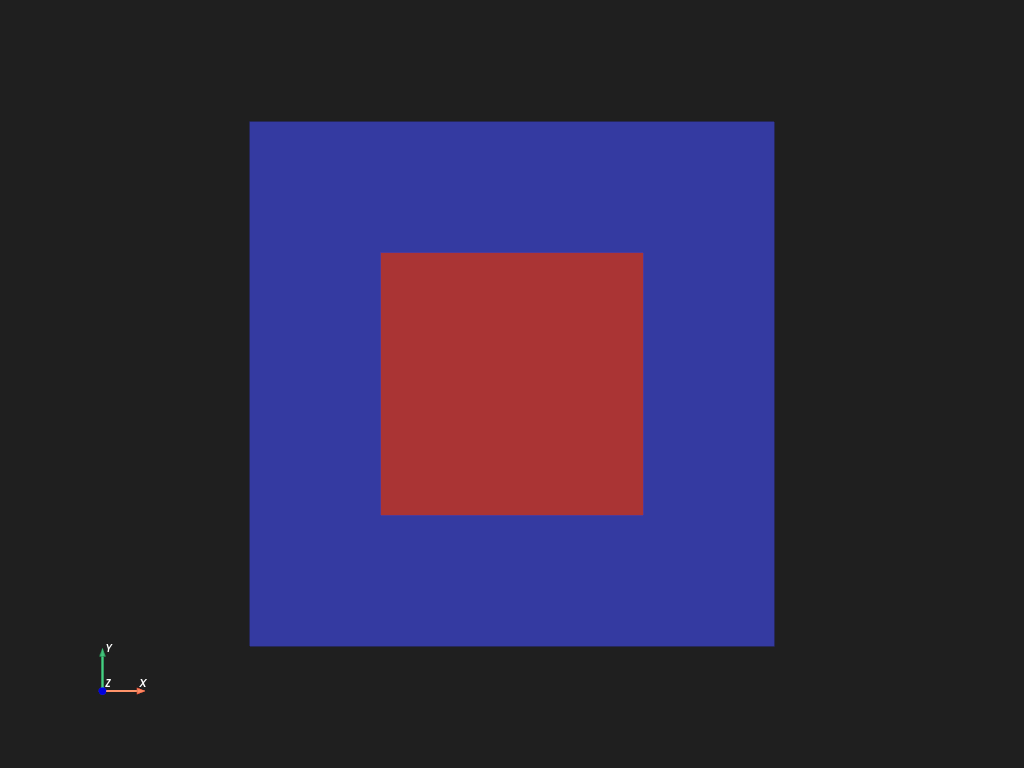

In [9]:
plot_structure(msh, props)

In [10]:
mass_matrix, stiffness_matrix = matrix_and_stiffness_matrix(msh, props)

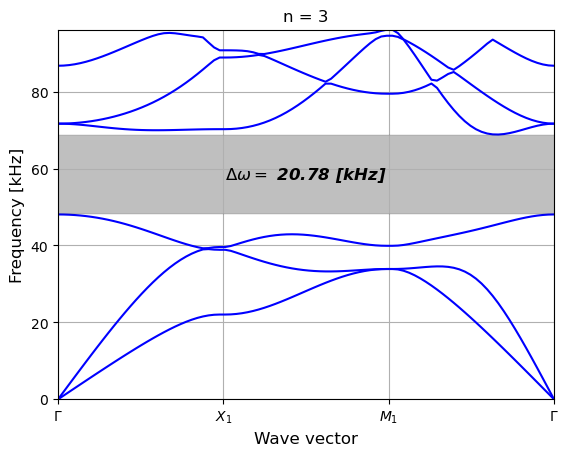

In [11]:
_ = bandgap(3, msh, mass_matrix, stiffness_matrix, N_eig = 6, plot= True, NINT=30)